### Remove scroll from figures

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Extend the size of the Window

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Load Modules

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
import netCDF4 as nc
import glob
import numpy as np
import pandas as pd
import xarray as xr
import itertools
import cftime
import cartopy.crs as ccrs
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm import tqdm

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import random
from jax.experimental import mesh_utils
from jax.sharding import PositionalSharding

import numpyro
numpyro.enable_x64()
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.contrib.nested_sampling import NestedSampler


INFO:2025-04-14 18:14:08,565:jax._src.xla_bridge:925: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-04-14 18:14:08,569:jax._src.xla_bridge:925: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


## Read CMIP Data into xarray

In [5]:
# Define paths
geoDataPath = '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/**/'
save_path = '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.nc'

In [6]:
# Find files
geoFiles = glob.glob(geoDataPath + '*.nc', recursive=True)
geoFiles


['/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1985.nc',
 '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1986.nc',
 '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1987.nc',
 '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1988.nc',
 '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1989.nc',
 '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1990.nc',
 '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1991.nc',
 '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1992.nc',
 '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1993.nc',
 '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1994.nc',
 '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1995.nc',

### Create variables for geo run

In [7]:

# geo_data = None
# for file in geoFiles:
#     if geo_data is None:
#         geo_data = xr.open_dataset(file)
#     else:
#         geo_data = geo_data.combine_first(xr.open_dataset(file))

# geo_data.to_netcdf(save_path)


In [8]:
DATA_SMOOTHING = 30
geo_data = xr.open_dataset(save_path).sel(level=2)
# geo_data['air'] = geo_data['air'] -273.15
geo_data

<xarray.Dataset> Size: 1GB
Dimensions:    (time: 16710, nbnds: 2, lat: 94, lon: 192)
Coordinates:
    level      float32 4B 2.0
  * lat        (lat) float32 376B 88.54 86.65 84.75 ... -84.75 -86.65 -88.54
  * lon        (lon) float32 768B 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
  * time       (time) datetime64[ns] 134kB 1979-01-01 1979-01-02 ... 2024-09-30
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) datetime64[ns] 267kB ...
    air        (time, lat, lon) float32 1GB ...
Attributes:
    Conventions:    CF-1.0
    title:          Daily NCEP/DOE Reanalysis 2
    comments:       Data is from \nNCEP/DOE AMIP-II Reanalysis (Reanalysis-2)...
    platform:       Model
    source:         NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model
    institution:    National Centers for Environmental Prediction
    dataset_title:  NCEP-DOE AMIP-II Reanalysis
    References:     https://www.psl.noaa.gov/data/gridded/data.ncep.reanalysi...
    source_url:     http://www.cpc.ncep.noaa.gov/products/wesley/reanalysis2/
    history:        created 2002/03 by RHS (netCDF2.3)\nConverted to chunked,...

### Explore seasonal function family based on powers of sines

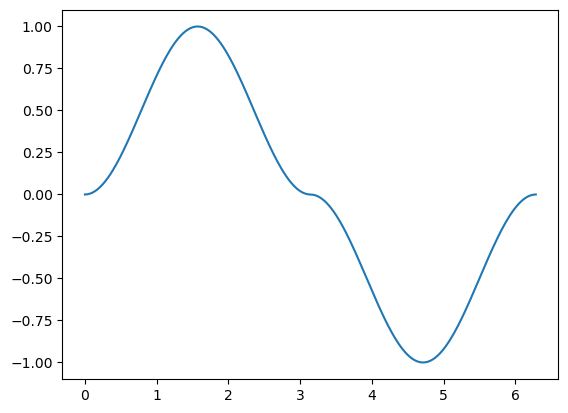

In [9]:
x = np.linspace(0,1,360)*2*np.pi
plt.plot(x, np.sign(np.sin(x))*(np.abs(np.sin(x)))**2)

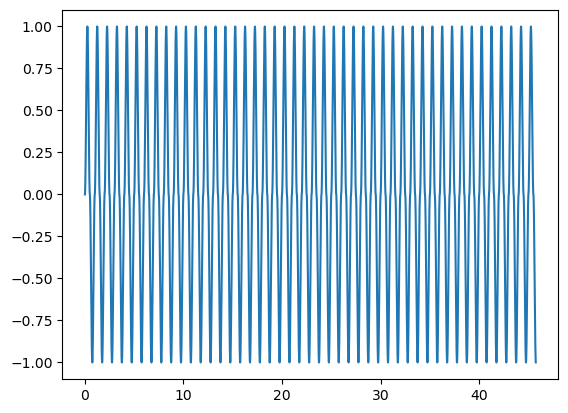

In [10]:
orbits = ((geo_data.time-np.min(geo_data.time))/np.timedelta64(1, 'D')/365.256).values

plt.plot(orbits, np.sign(np.sin(orbits*2*np.pi))*(np.abs(np.sin(orbits*2*np.pi)))**2)

### Rebin data to coarser grids

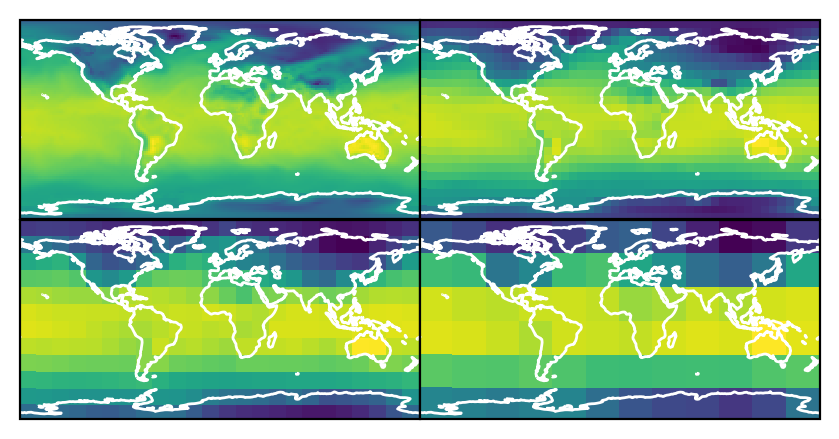

In [11]:
vmin = None
vmax = None

fig = plt.figure(figsize=2*np.array([2, 1]), dpi=200)
gs0 = fig.add_gridspec(2, 2, wspace=0.0, hspace=0, left=0, right=1, bottom=0, top=1)

ax = fig.add_subplot(gs0[0, 0], projection=ccrs.PlateCarree())
geo_data.air.isel(time=0).plot(ax=ax, add_colorbar=False, vmin=vmin, vmax=vmax, add_labels=False)
ax.coastlines(color='w')

geo_data_coarse8 = geo_data.coarsen(lon=4, lat=4, time=DATA_SMOOTHING, boundary='pad').mean()
ax = fig.add_subplot(gs0[0, 1], projection=ccrs.PlateCarree())
geo_data_coarse8.air.isel(time=0).plot(ax=ax, add_colorbar=False, vmin=vmin, vmax=vmax, add_labels=False)
ax.coastlines(color='w')

geo_data_coarse15 = geo_data.coarsen(lon=8, lat=8, time=DATA_SMOOTHING, boundary='pad').mean()
ax = fig.add_subplot(gs0[1, 0], projection=ccrs.PlateCarree())
geo_data_coarse15.air.isel(time=0).plot(ax=ax, add_colorbar=False, vmin=vmin, vmax=vmax, add_labels=False)
ax.coastlines(color='w')

geo_data_coarse30 = geo_data.coarsen(lon=16, lat=16, time=DATA_SMOOTHING, boundary='pad').mean()
ax = fig.add_subplot(gs0[1, 1], projection=ccrs.PlateCarree())
geo_data_coarse30.air.isel(time=0).plot(ax=ax, add_colorbar=False, vmin=vmin, vmax=vmax, add_labels=False)
ax.coastlines(color='w')

In [12]:
np.percentile(geo_data_coarse30.air.values, [1, 25,50,75,99])

array([229.35019897, 264.05605316, 282.2605896 , 296.55432892,
       301.59566864])

In [13]:
geo_data_coarse30

<xarray.Dataset> Size: 174kB
Dimensions:    (time: 557, nbnds: 2, lat: 6, lon: 12)
Coordinates:
    level      float32 4B 2.0
  * lat        (lat) float32 24B 74.28 43.81 13.33 -17.14 -47.62 -76.18
  * lon        (lon) float32 48B 14.06 44.06 74.06 104.1 ... 284.1 314.1 344.1
  * time       (time) datetime64[ns] 4kB 1979-01-15T12:00:00 ... 2024-09-15T1...
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) datetime64[ns] 9kB 1979-01-15T12:00:00 ... 2024-...
    air        (time, lat, lon) float32 160kB 258.0 251.4 244.2 ... 248.3 245.5
Attributes:
    Conventions:    CF-1.0
    title:          Daily NCEP/DOE Reanalysis 2
    comments:       Data is from \nNCEP/DOE AMIP-II Reanalysis (Reanalysis-2)...
    platform:       Model
    source:         NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model
    institution:    National Centers for Environmental Prediction
    dataset_title:  NCEP-DOE AMIP-II Reanalysis
    References:     https://www.psl.noaa.gov/data/gridded/data.ncep.reanalysi...
    source_url:     http://www.cpc.ncep.noaa.gov/products/wesley/reanalysis2/
    history:        created 2002/03 by RHS (netCDF2.3)\nConverted to chunked,...

### Read CO2 concentration

<xarray.Dataset> Size: 8kB
Dimensions:  (time: 516)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1974-06-06T01:36:00 ... 2024-10-15T20:...
Data variables:
    CO2      (time) float64 4kB 332.6 331.2 329.0 327.1 ... 424.8 422.0 422.3

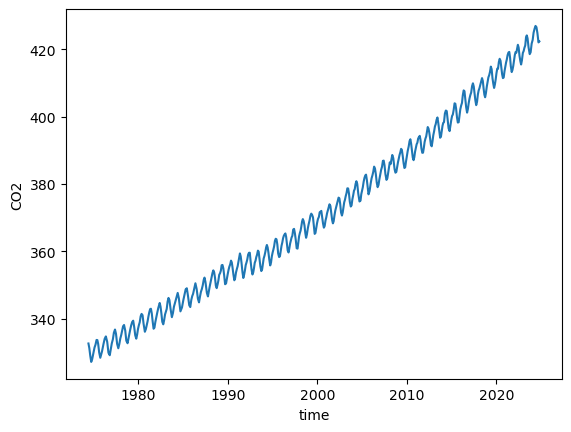

In [17]:
df = pd.read_csv('/d0/amunozj/git_repos/interconnection-sun-climate/co2_daily_mlo.csv', engine="c", header=32)
df['time'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df = df.set_index('time', drop=True).loc[:,['CO2']]

co2_data = xr.Dataset.from_dataframe(df).coarsen(time=DATA_SMOOTHING, boundary='pad').mean()
# co2_data = co2_data.interp(time=geo_data_coarse30.time.values)
co2_data.CO2.plot()
co2_data

### Read El Niño index

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_234602/3152471513.py:1: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_table('/d0/amunozj/git_repos/interconnection-sun-climate/ENI/detrend.nino34.ascii.txt', engine="c", sep='\s+')


<xarray.Dataset> Size: 36kB
Dimensions:     (time: 897)
Coordinates:
  * time        (time) datetime64[ns] 7kB 1950-01-15 1950-02-15 ... 2024-09-15
Data variables:
    TOTAL       (time) float64 7kB 24.56 25.07 25.88 26.29 ... 27.34 26.74 26.44
    ClimAdjust  (time) float64 7kB 26.18 26.39 26.95 27.39 ... 27.29 26.86 26.72
    oni         (time) float64 7kB -1.62 -1.32 -1.07 -1.1 ... 0.05 -0.12 -0.28
    normalized  (time) float64 7kB -1.904 -1.555 -1.264 ... -0.1576 -0.3439

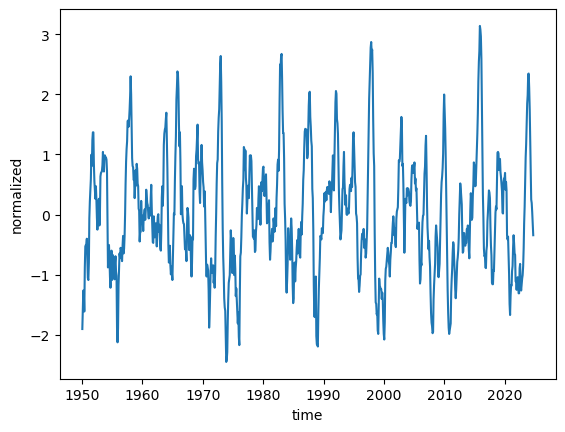

In [21]:
df = pd.read_table('/d0/amunozj/git_repos/interconnection-sun-climate/ENI/detrend.nino34.ascii.txt', engine="c", sep='\s+')
df['DAY'] = 15
df['time'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
df = df.set_index('time', drop=True).loc[:,['TOTAL', 'ClimAdjust']]

oni_data = xr.Dataset.from_dataframe(df)
# oni_data = oni_data.interp(time=geo_data_coarse30.time.values, kwargs={'fill_value':'extrapolate'})
# oni_data.ClimAdjust.plot()
# oni_data.TOTAL.plot()

oni_data['oni'] = oni_data.TOTAL - oni_data.ClimAdjust
oni_data['normalized'] = ((oni_data.oni - oni_data.oni.mean())/oni_data.oni.std())


oni_data.normalized.plot()
oni_data

<xarray.Dataset> Size: 35kB
Dimensions:               (time: 725)
Coordinates:
  * time                  (time) datetime64[ns] 6kB 1964-05-01 ... 2024-09-01
Data variables:
    FractionalDate        (time) float64 6kB 1.964e+03 1.964e+03 ... 2.025e+03
    UncorrectedCountRate  (time) int64 6kB 5945 6008 6059 ... 5637 5553 5176
    CorrectedCountRate    (time) int64 6kB 6424 6427 6461 ... 5983 5848 5715
    Pressure              (time) float64 6kB 1.011e+03 1.009e+03 ... 1.014e+03
    normalized            (time) float64 6kB 0.6251 0.6333 ... -0.9525 -1.317

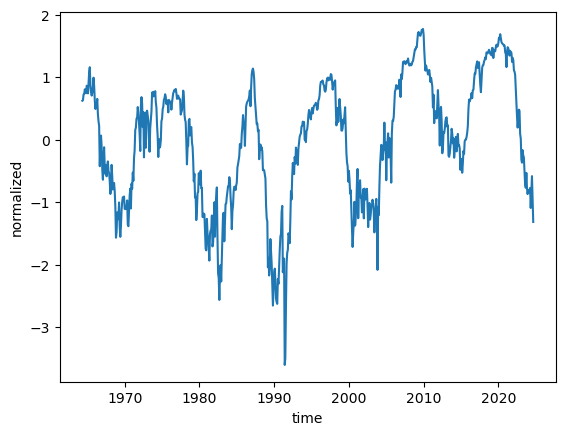

In [33]:
# Define path
crDataPath = '../../data/cosmic_rays/OULU_1964_05_01 _00_00_2024_10_28 _23_30.csv'

# Read cr monthly average file with custom column names\
cr = pd.read_csv(crDataPath)
cr['time'] = pd.to_datetime(cr['Timestamp']).dt.tz_localize(None).astype('datetime64[ns]')
cr = cr.drop(columns='Timestamp')
cr = cr.set_index('time', drop=True)
cr = xr.Dataset.from_dataframe(cr)

# cr['crav'] = cr['CorrectedCountRate[cts/min]'].rolling(time=365, min_periods=1, center=True).mean()
# cr = cr.sel(time=slice(np.min(hist_sol.time.data)-pd.Timedelta(0, 'd'), np.max(hist_sol.time.data)))

# # Convert to seasonal average
# cr = cr['CorrectedCountRate[cts/min]'].resample(time='QS-DEC').mean().to_dataset(name = 'cr')

# # Reset index to middle of the season
# cr['time'] = cr['time'] + pd.to_timedelta(45, 'd')
# # Select only whole seasons
# cr = cr.sel(time=slice('1983-01-01', '2022-09-30'))
# cr['time'] = xr.CFTimeIndex.to_datetimeindex(cr['time'], unsafe=True)

cr['normalized'] = ((cr.CorrectedCountRate - cr.CorrectedCountRate.mean())/cr.CorrectedCountRate.std())
cr.normalized.plot()

cr

### Randomly select latitude and longitude

In [38]:
lat_index = np.random.randint(geo_data_coarse30.air.values.shape[-2])
lon_index = np.random.randint(geo_data_coarse30.air.values.shape[-1])
lat = geo_data_coarse30.lat.values[lat_index]
lon = geo_data_coarse30.lon.values[lon_index]

target_variable = geo_data_coarse30.air.sel(lat=lat, lon=lon).values
orbits = ((geo_data_coarse30.time-np.min(geo_data_coarse30.time))/np.timedelta64(1, 'D')/365.256).values

lat_index, lon_index, lat, lon

(5, 2, -76.184326, 74.0625)

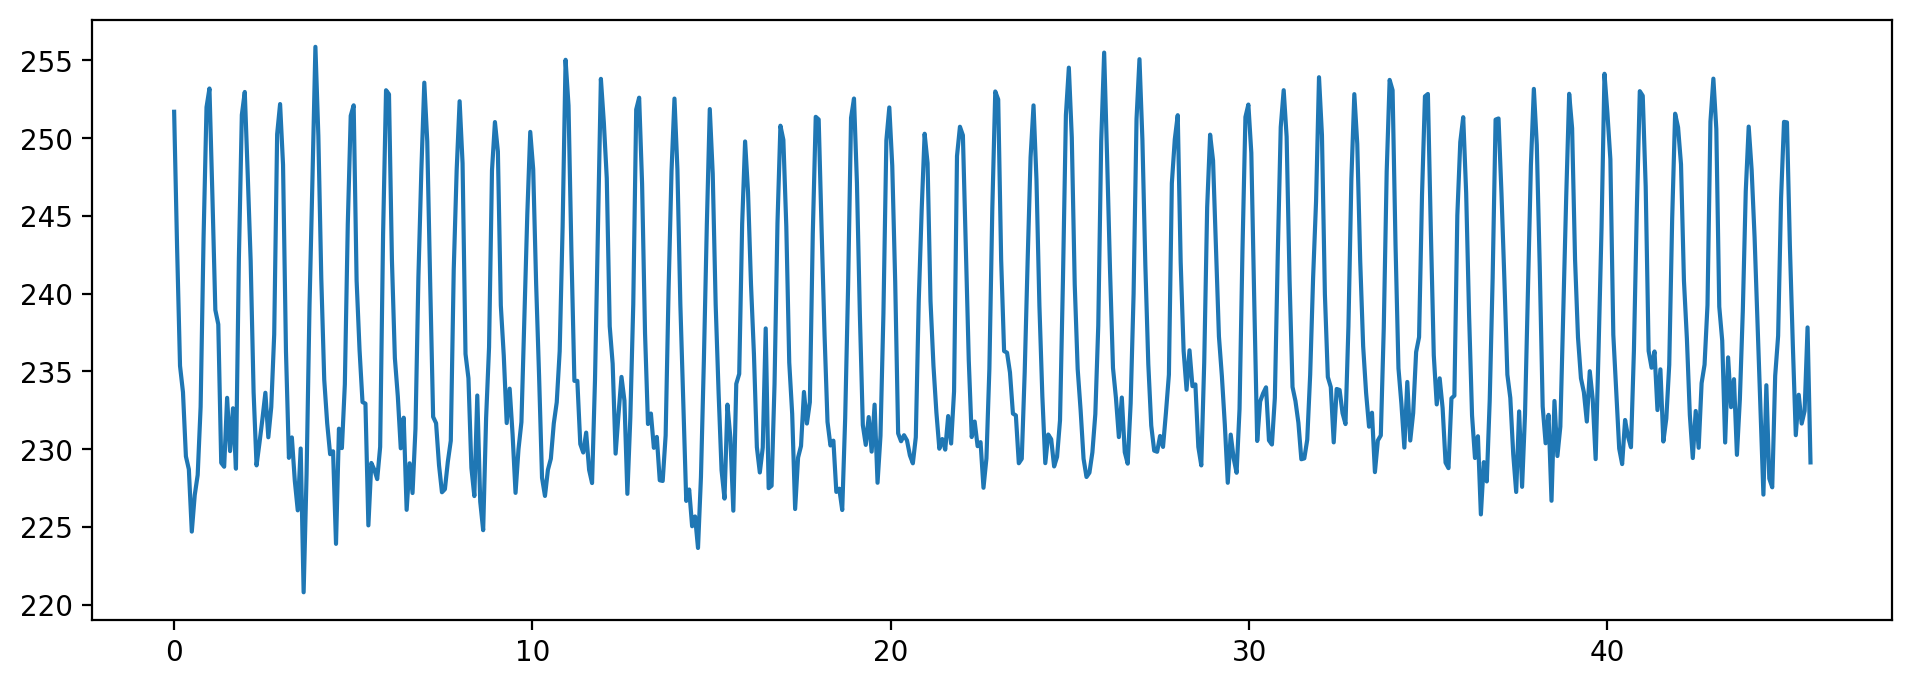

In [39]:
fig = plt.figure(figsize=np.array([9, 3]), dpi=200)
gs0 = fig.add_gridspec(1, 1, wspace=0.0, hspace=0, left=0, right=1, bottom=0, top=1)

ax = fig.add_subplot(gs0[0, 0])
ax.plot(orbits, target_variable)

### Nested sampling parameters and full model

In [40]:
constructor_kwargs = {'max_samples': 20000, 'parameter_estimation':True, 'verbose':False}

In [41]:
def single_lat_lon_model(time, target_variable=None, co2=False, seasonal=False, oni=None, cr=None):  

    orbits = ((time-np.min(time))/np.timedelta64(1, 'D')/365.256).values

    # Intrinsic noise
    sigma = numpyro.sample("sigma", dist.HalfNormal(20.0))

    # Offset
    offset = numpyro.sample("offset", dist.Normal(270.0, 40.0))
    target_variable_estimate = offset

    # Seasonal
    if seasonal:
        seasonal_shift = numpyro.sample("seasonal_shift", dist.Normal(0.0, 1.0))
        seasonal_amplitude = numpyro.sample("seasonal_amplitude", dist.Normal(20.0, 20.0))
        seasonal_exponent = numpyro.sample("seasonal_exponent", dist.HalfNormal(2.0))

        sin_orbits = jnp.sin((orbits - seasonal_shift)*2*jnp.pi)
        target_variable_estimate = (target_variable_estimate
                                    + seasonal_amplitude*jnp.sign(sin_orbits)*jnp.pow(jnp.abs(sin_orbits), seasonal_exponent) )

    # CO2
    if co2:
        co2_gain = numpyro.sample("co2_gain", dist.Normal(20.0,  20.0))
        target_variable_estimate = target_variable_estimate +  orbits/jnp.max(orbits)*co2_gain


    # ONI
    if oni is not None:
        oni_gain = numpyro.sample("oni_gain", dist.Normal(0.0,  2.0))
        oni_shift = numpyro.sample("oni_shift", dist.Normal(0.0, 0.5))

        orbits_oni = ((oni.time-np.min(time))/np.timedelta64(1, 'D')/365.256).values
        target_variable_estimate = (target_variable_estimate
                                    + oni_gain*jnp.interp(orbits-jnp.abs(oni_shift), orbits_oni, oni.normalized.values) )


    # Cosmic Rays
    if cr is not None:
        cr_gain = numpyro.sample("cr_gain", dist.Normal(0.0,  2.0))
        cr_shift = numpyro.sample("cr_shift", dist.Normal(0.0, 1.0))

        orbits_cr = ((cr.time-np.min(time))/np.timedelta64(1, 'D')/365.256).values
        target_variable_estimate = (target_variable_estimate
                                    + cr_gain*jnp.interp(orbits-jnp.abs(cr_shift), orbits_cr, cr.normalized.values)) 


    with numpyro.plate("times", target_variable.shape[0]):
        numpyro.sample("obs", dist.Normal(target_variable_estimate, sigma), obs=target_variable)


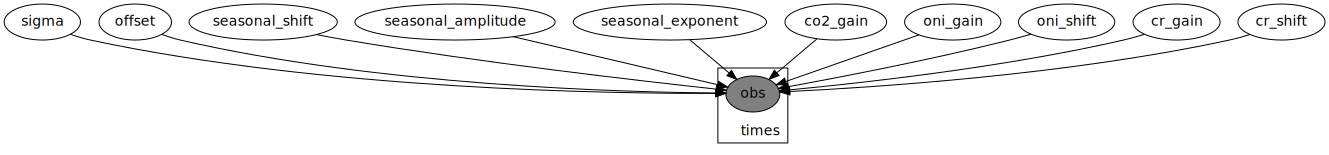

In [42]:
numpyro.render_model(single_lat_lon_model, model_args=(geo_data_coarse30.time, 
                                                       target_variable,
                                                       True, True, oni_data, cr))

### Fit numpyro model only with CO2 increase

INFO:jaxns:Number of parallel Markov-chains set to: 21


--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 113721
samples: 4501
phantom samples: 3840
likelihood evals / sample: 25.3
phantom fraction (%): 85.3%
--------
logZ=-1544.6 +- 1.2
max(logL)=-1520.7
H=-20.8
ESS=44
--------
co2_gain: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
co2_gain: 2.18 +- 0.4 | 1.64 / 2.19 / 2.63 | 2.36 | 2.36
--------
offset: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
offset: 236.21 +- 0.27 | 235.92 / 236.19 / 236.55 | 236.14 | 236.14
--------
seasonal_amplitude: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
seasonal_amplitude: 11.14 +- 0.24 | 10.87 / 11.16 / 11.43 | 10.98 | 10.98
--------
seasonal_exponent: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
seasonal_exponent: 1.313 +- 0.056 | 1.243 / 1.304 / 1.38 | 1.216 | 1.216
--------
seasonal_shift: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
seasonal_shift:

/d0/amunozj/.conda/envs/sun-climate-bayes/lib/python3.12/site-packages/jaxns/plotting.py:45: UserWarning: Found samples with zero likelihood evaluations.
  warnings.warn("Found samples with zero likelihood evaluations.")


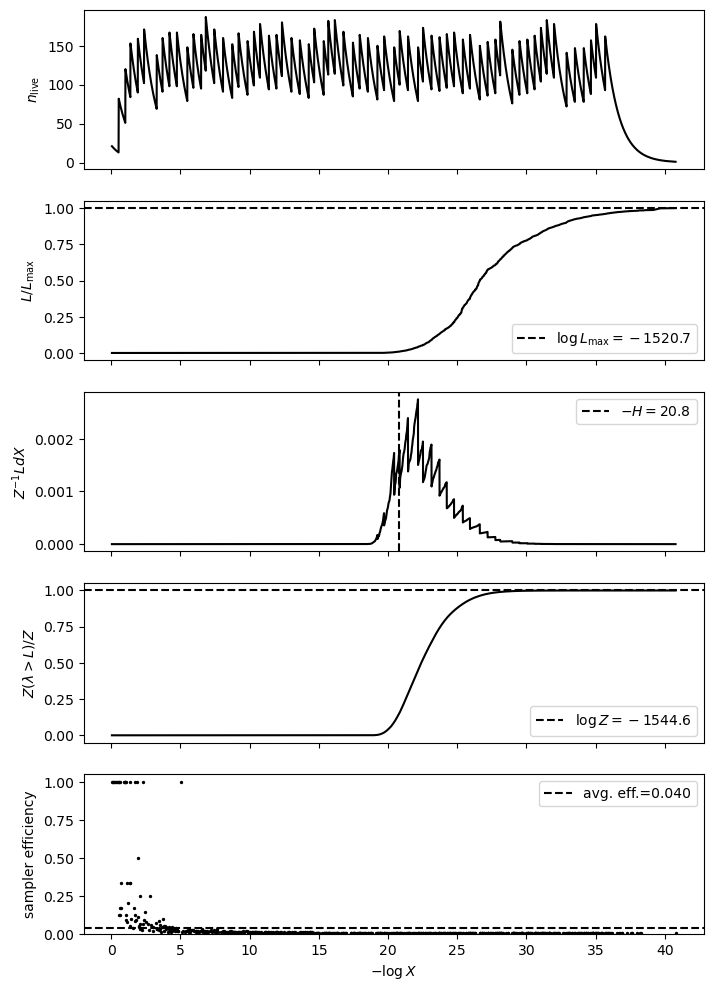

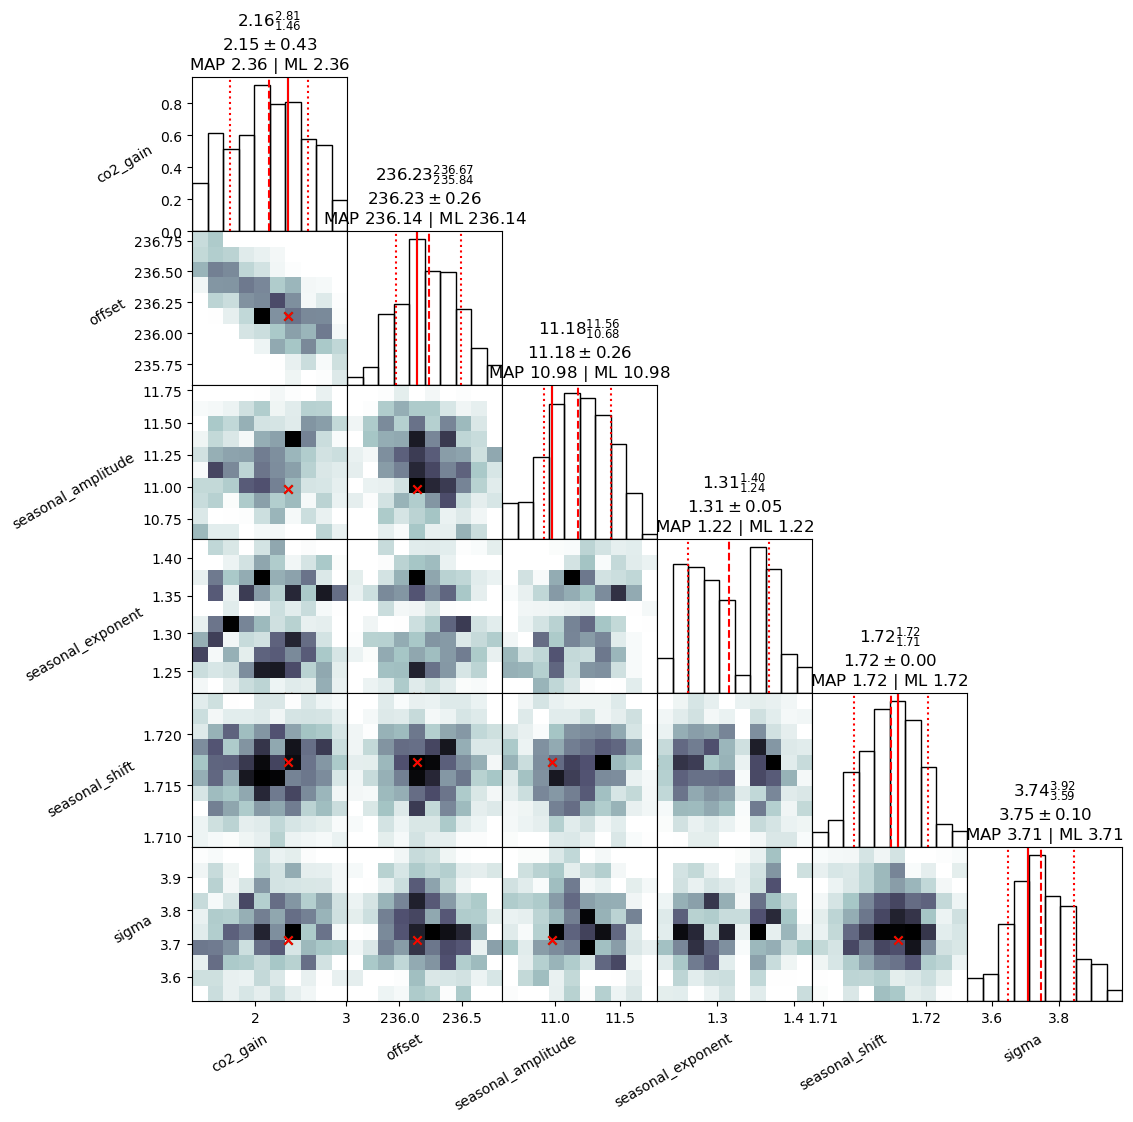

In [43]:
ns_co2_seasonal = NestedSampler(single_lat_lon_model, constructor_kwargs=constructor_kwargs)
ns_co2_seasonal.run(random.PRNGKey(2), geo_data_coarse30.time, target_variable,
                                                    co2=True, seasonal=True, oni=None, cr=None)
ns_co2_seasonal.print_summary()
ns_co2_seasonal.diagnostics()

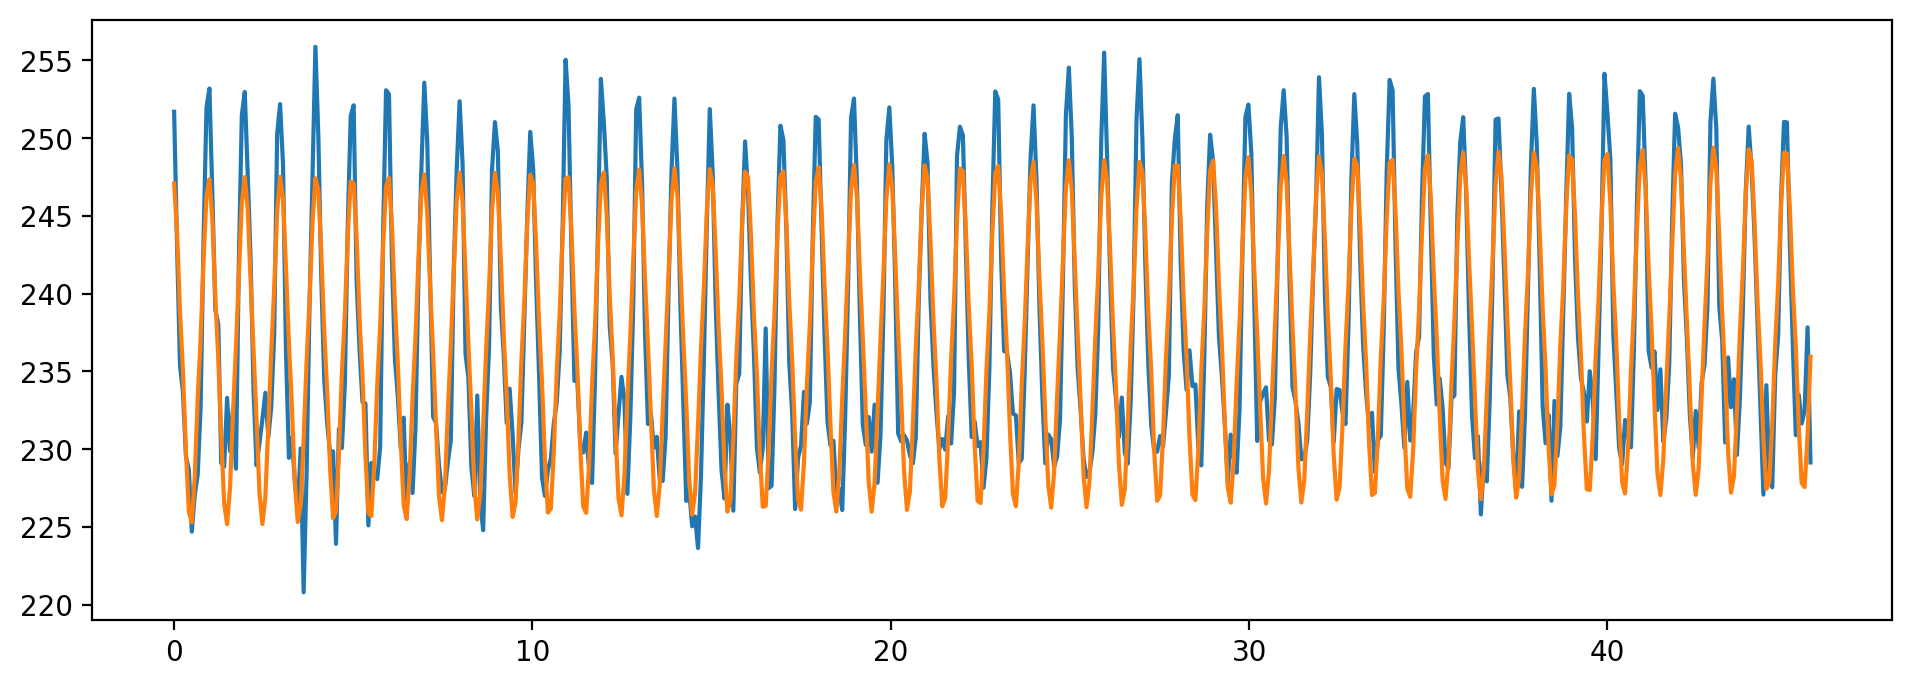

In [45]:
samples = ns_co2_seasonal.get_samples(random.PRNGKey(3), num_samples=1000)
log_Z_mean = np.array(ns_co2_seasonal._results.log_Z_mean).astype('float64')

sigma = np.array(jnp.median(samples['sigma'])).astype('float64')

# Offset
offset = np.array(jnp.median(samples['offset'])).astype('float64')

# Seasonal
seasonal_shift = np.array(jnp.median(samples['seasonal_shift'])).astype('float64')
seasonal_amplitude = np.array(jnp.median(samples['seasonal_amplitude'])).astype('float64')
seasonal_exponent = np.array(jnp.median(samples['seasonal_exponent'])).astype('float64')

# CO2
co2_gain = np.array(jnp.median(samples['co2_gain'])).astype('float64')

fig = plt.figure(figsize=np.array([9, 3]), dpi=200)
gs0 = fig.add_gridspec(1, 1, wspace=0.0, hspace=0, left=0, right=1, bottom=0, top=1)

ax = fig.add_subplot(gs0[0, 0])
ax.plot(orbits, target_variable)


sin_orbits = jnp.sin((orbits - seasonal_shift)*2*jnp.pi)
precipitation_estimate = (seasonal_amplitude*jnp.sign(sin_orbits)*jnp.pow(jnp.abs(sin_orbits), seasonal_exponent)
                            + orbits/jnp.max(orbits)*co2_gain  + offset)
ax.plot(orbits, precipitation_estimate)


INFO:jaxns:Number of parallel Markov-chains set to: 16


--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 104714
samples: 4336
phantom samples: 3840
likelihood evals / sample: 24.1
phantom fraction (%): 88.6%
--------
logZ=-1544.6 +- 1.4
max(logL)=-1520.6
H=-20.53
ESS=28
--------
co2_gain: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
co2_gain: 2.42 +- 0.51 | 1.86 / 2.4 / 3.07 | 2.35 | 2.35
--------
offset: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
offset: 236.11 +- 0.29 | 235.77 / 236.1 / 236.44 | 236.13 | 236.13
--------
oni_gain: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
oni_gain: 0.13 +- 0.16 | -0.12 / 0.17 / 0.31 | 0.03 | 0.03
--------
oni_shift: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
oni_shift: 0.666 +- 0.078 | 0.581 / 0.65 / 0.788 | 0.627 | 0.627
--------
seasonal_amplitude: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
seasonal_amplitude: 10.94 +- 0.24 | 10.59 / 10.98 / 

/d0/amunozj/.conda/envs/sun-climate-bayes/lib/python3.12/site-packages/jaxns/plotting.py:45: UserWarning: Found samples with zero likelihood evaluations.
  warnings.warn("Found samples with zero likelihood evaluations.")


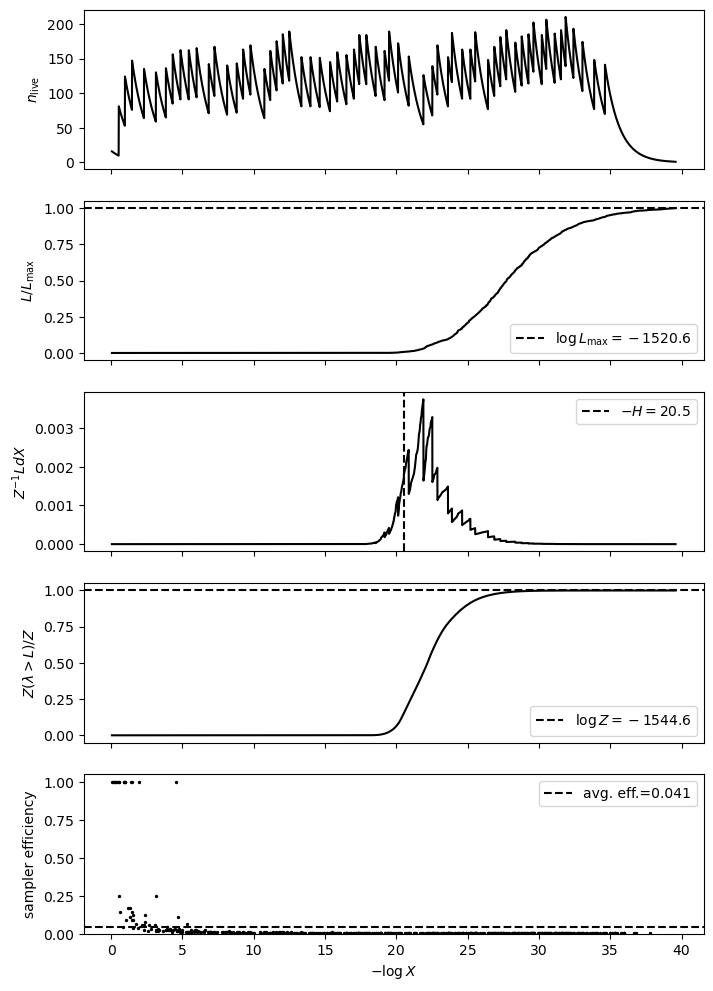

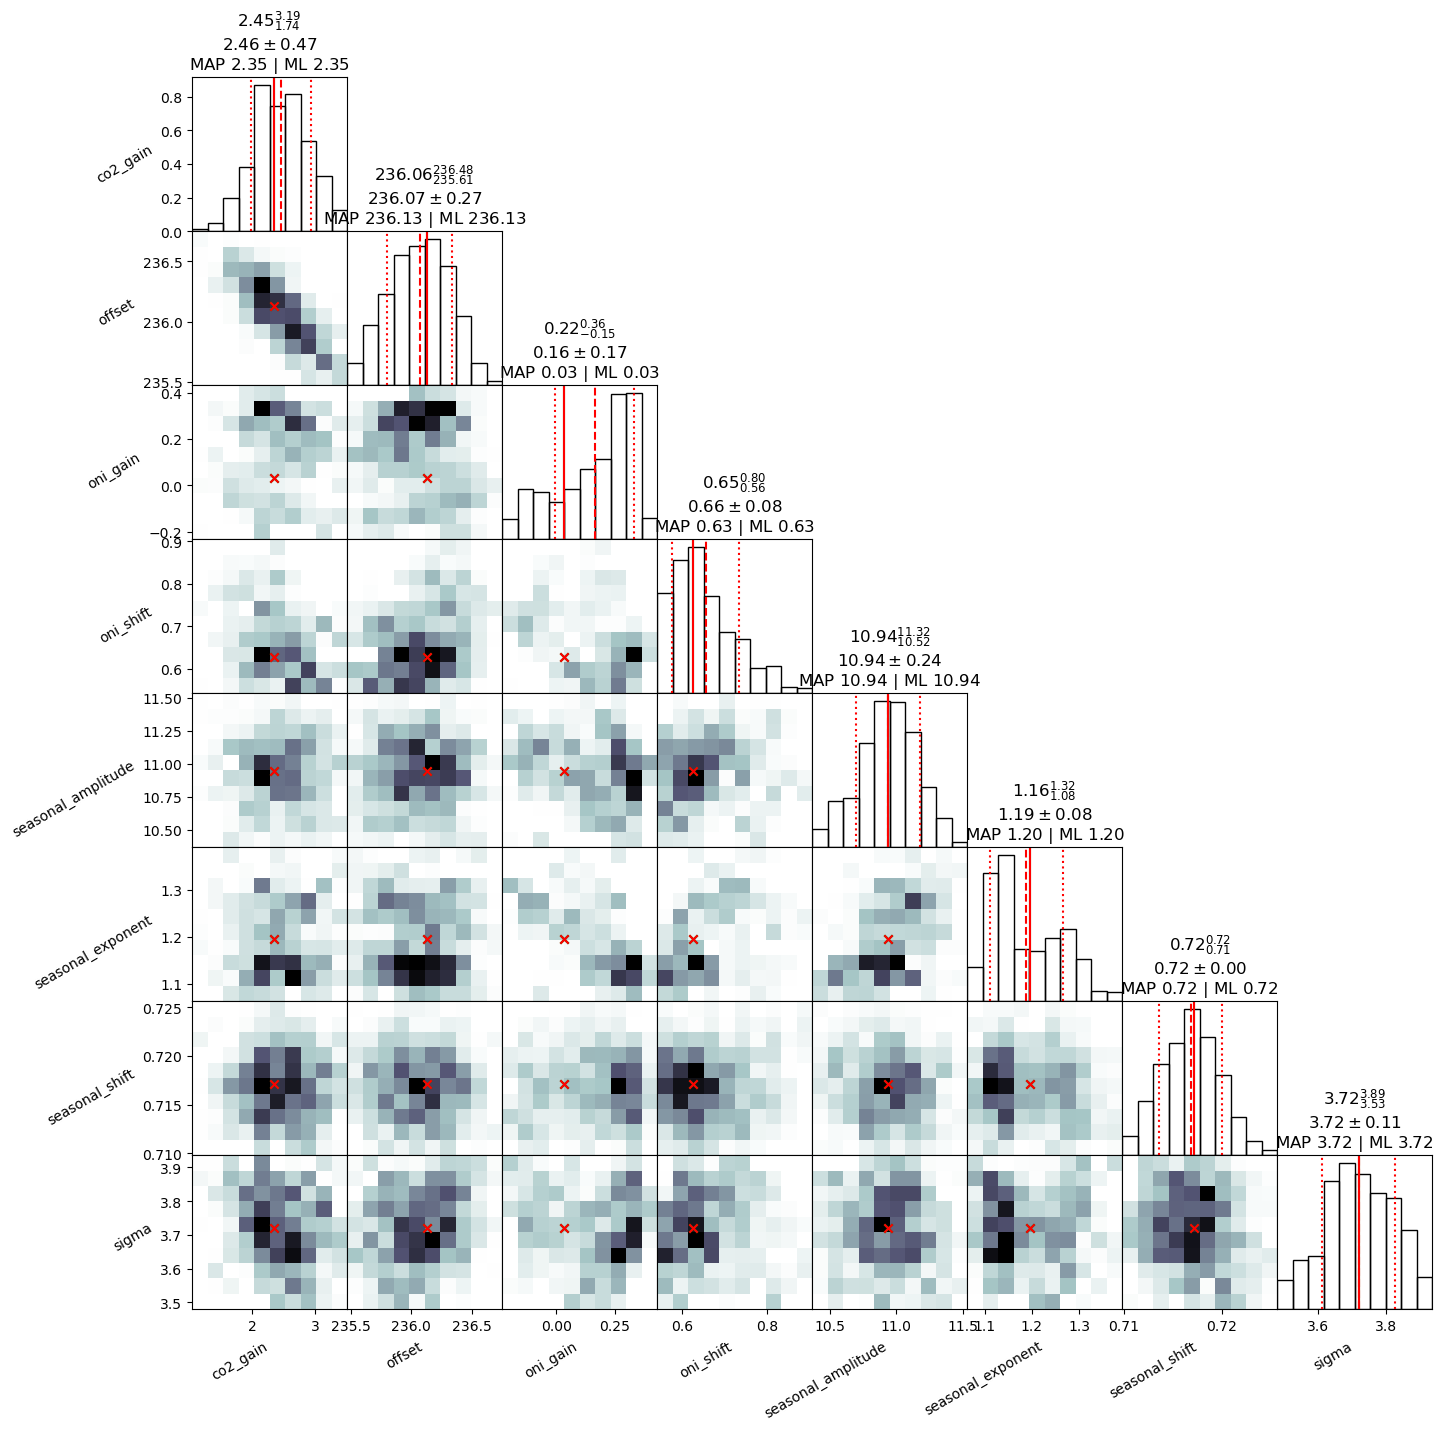

In [47]:
ns_co2_seasonal_oni = NestedSampler(single_lat_lon_model, constructor_kwargs=constructor_kwargs)
ns_co2_seasonal_oni.run(random.PRNGKey(2), geo_data_coarse30.time, target_variable,
                                                    True, True, oni_data, None)
ns_co2_seasonal_oni.print_summary()
ns_co2_seasonal_oni.diagnostics()

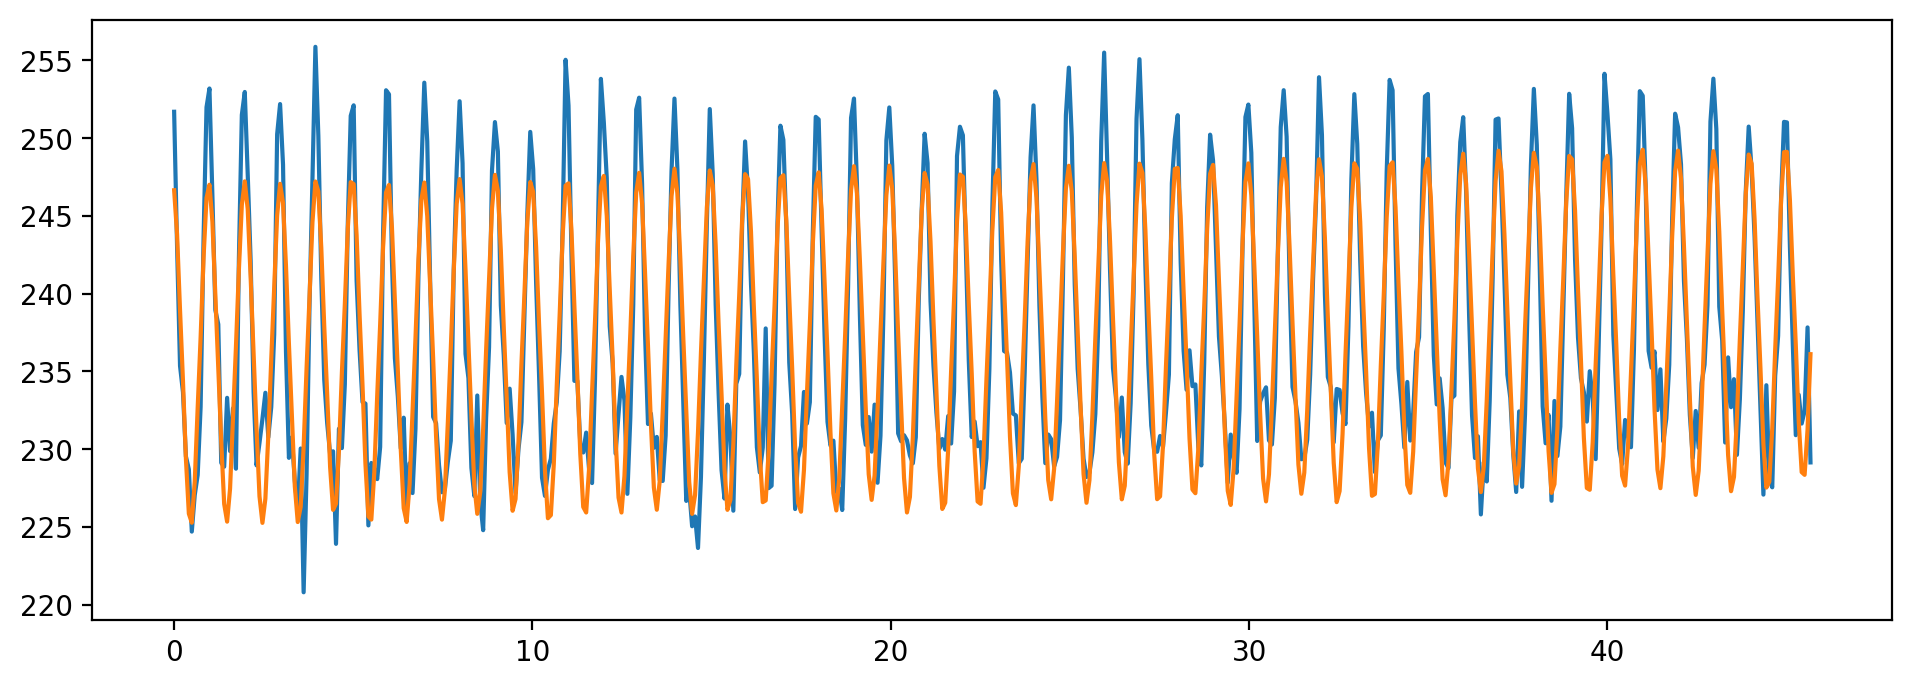

In [48]:
samples = ns_co2_seasonal_oni.get_samples(random.PRNGKey(3), num_samples=1000)
log_Z_mean = np.array(ns_co2_seasonal_oni._results.log_Z_mean).astype('float64')

sigma = np.array(jnp.median(samples['sigma'])).astype('float64')

# Offset
offset = np.array(jnp.median(samples['offset'])).astype('float64')

# Seasonal
seasonal_shift = np.array(jnp.median(samples['seasonal_shift'])).astype('float64')
seasonal_amplitude = np.array(jnp.median(samples['seasonal_amplitude'])).astype('float64')
seasonal_exponent = np.array(jnp.median(samples['seasonal_exponent'])).astype('float64')

# ONI
oni = oni_data
orbits_oni = ((oni.time-np.min(geo_data_coarse30.time))/np.timedelta64(1, 'D')/365.256).values
oni_gain = np.array(jnp.median(samples['oni_gain'])).astype('float64')
oni_shift = np.array(jnp.median(samples['oni_shift'])).astype('float64')

# CO2
co2_gain = np.array(jnp.median(samples['co2_gain'])).astype('float64')

fig = plt.figure(figsize=np.array([9, 3]), dpi=200)
gs0 = fig.add_gridspec(1, 1, wspace=0.0, hspace=0, left=0, right=1, bottom=0, top=1)

ax = fig.add_subplot(gs0[0, 0])
ax.plot(orbits, target_variable)


sin_orbits = jnp.sin((orbits - seasonal_shift)*2*jnp.pi)
precipitation_estimate = (seasonal_amplitude*jnp.sign(sin_orbits)*jnp.pow(jnp.abs(sin_orbits), seasonal_exponent)
                            + orbits/jnp.max(orbits)*co2_gain  + offset
                            + oni_gain*jnp.interp(orbits-jnp.abs(oni_shift), orbits_oni, oni.normalized.values))
ax.plot(orbits, precipitation_estimate)


INFO:jaxns:Number of parallel Markov-chains set to: 16


--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 106164
samples: 4336
phantom samples: 3840
likelihood evals / sample: 24.5
phantom fraction (%): 88.6%
--------
logZ=-1546.1 +- 1.5
max(logL)=-1520.5
H=-22.03
ESS=31
--------
co2_gain: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
co2_gain: 2.61 +- 0.48 | 1.98 / 2.61 / 3.2 | 2.42 | 2.42
--------
cr_gain: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
cr_gain: -0.131 +- 0.077 | -0.237 / -0.138 / -0.038 | -0.073 | -0.073
--------
cr_shift: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
cr_shift: -0.619 +- 0.048 | -0.665 / -0.624 / -0.567 | -0.625 | -0.625
--------
offset: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
offset: 236.0 +- 0.27 | 235.62 / 236.02 / 236.31 | 236.12 | 236.12
--------
seasonal_amplitude: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
seasonal_amplitude: -11.2 +- 0.22 | -

/d0/amunozj/.conda/envs/sun-climate-bayes/lib/python3.12/site-packages/jaxns/plotting.py:45: UserWarning: Found samples with zero likelihood evaluations.
  warnings.warn("Found samples with zero likelihood evaluations.")


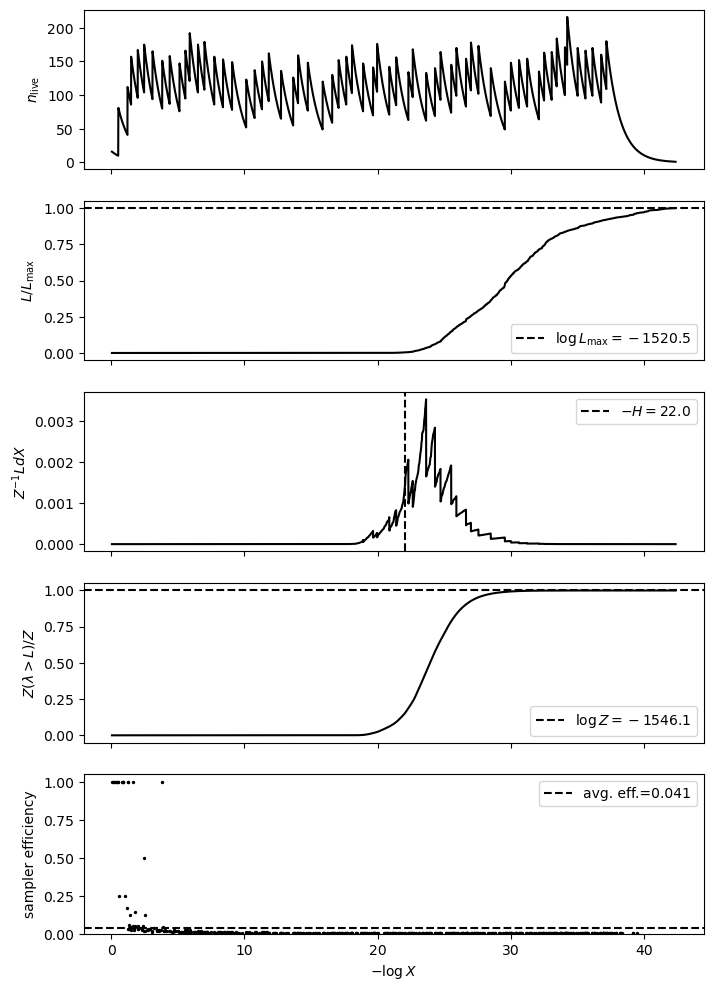

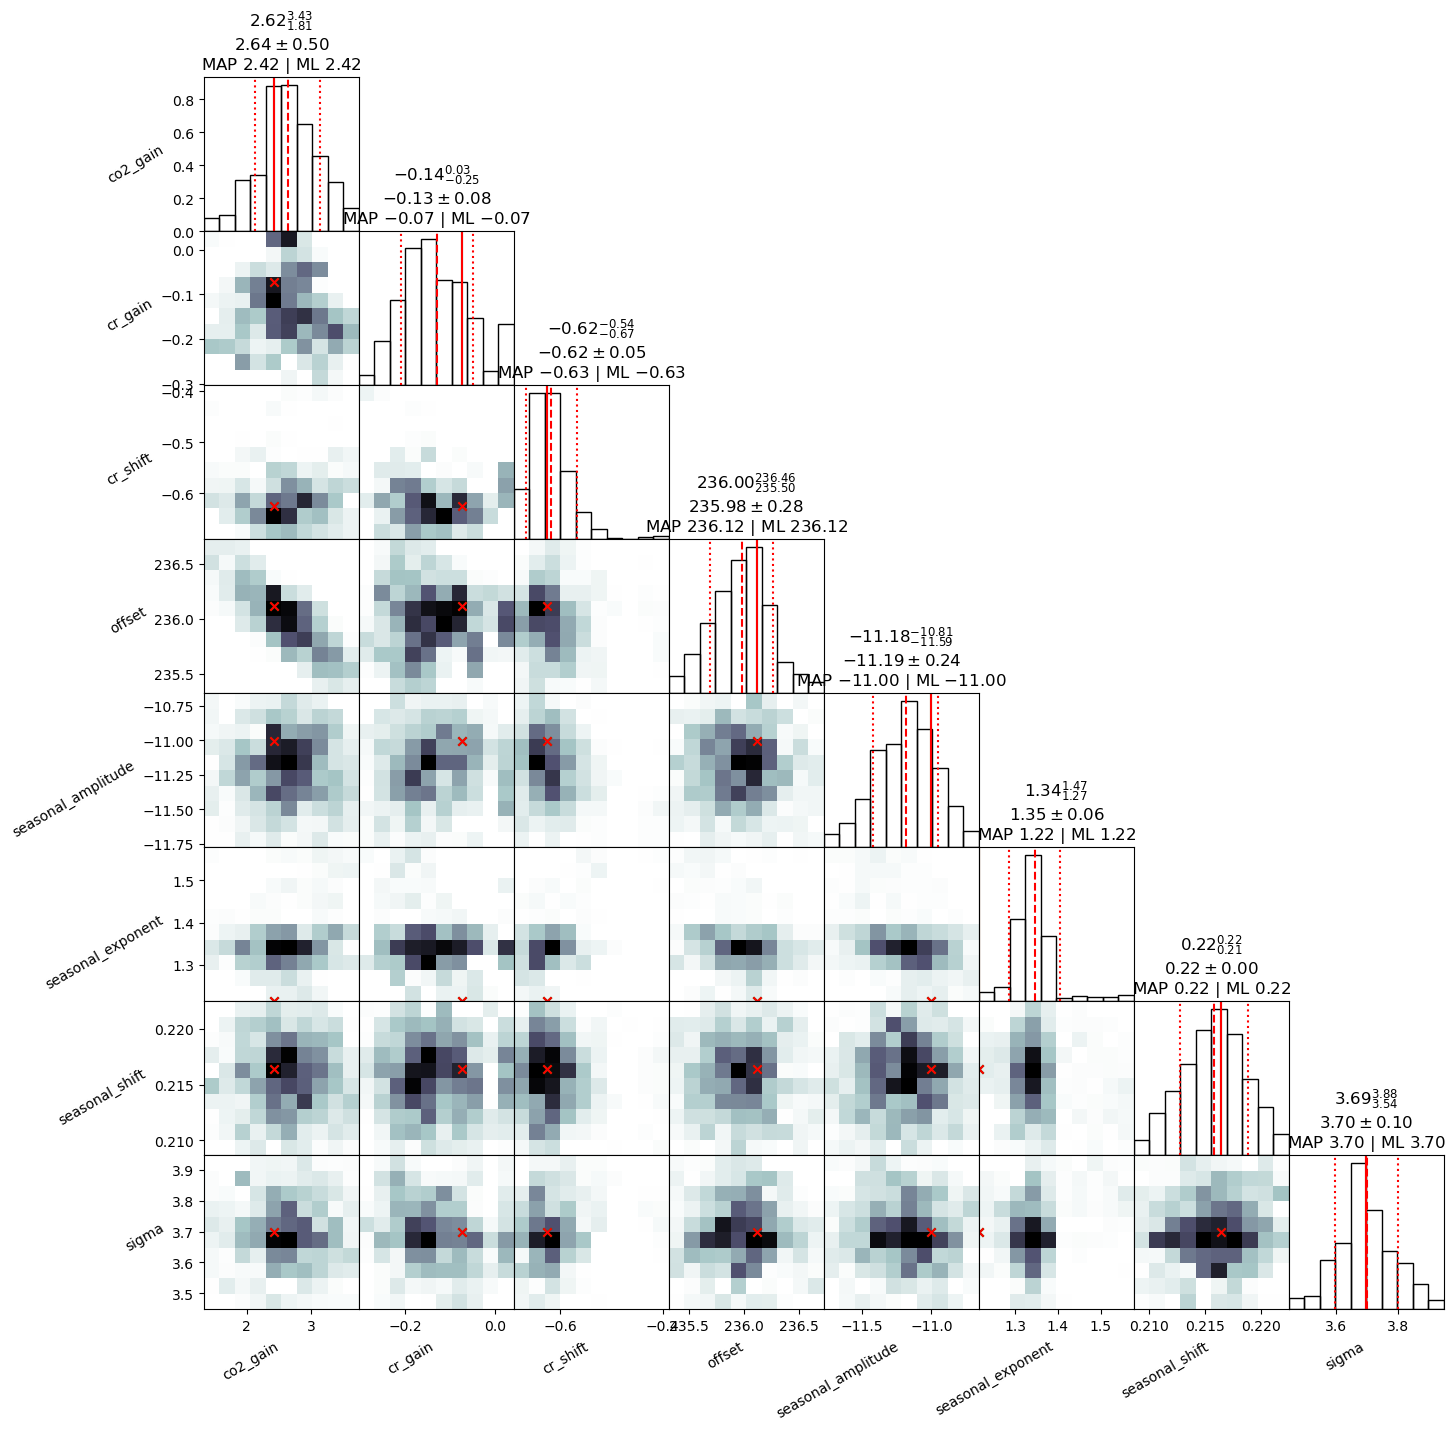

In [49]:
ns_co2_seasonal_cr = NestedSampler(single_lat_lon_model, constructor_kwargs=constructor_kwargs)
ns_co2_seasonal_cr.run(random.PRNGKey(2), geo_data_coarse30.time, target_variable,
                                                    True, True, None, cr)
ns_co2_seasonal_cr.print_summary()
ns_co2_seasonal_cr.diagnostics()

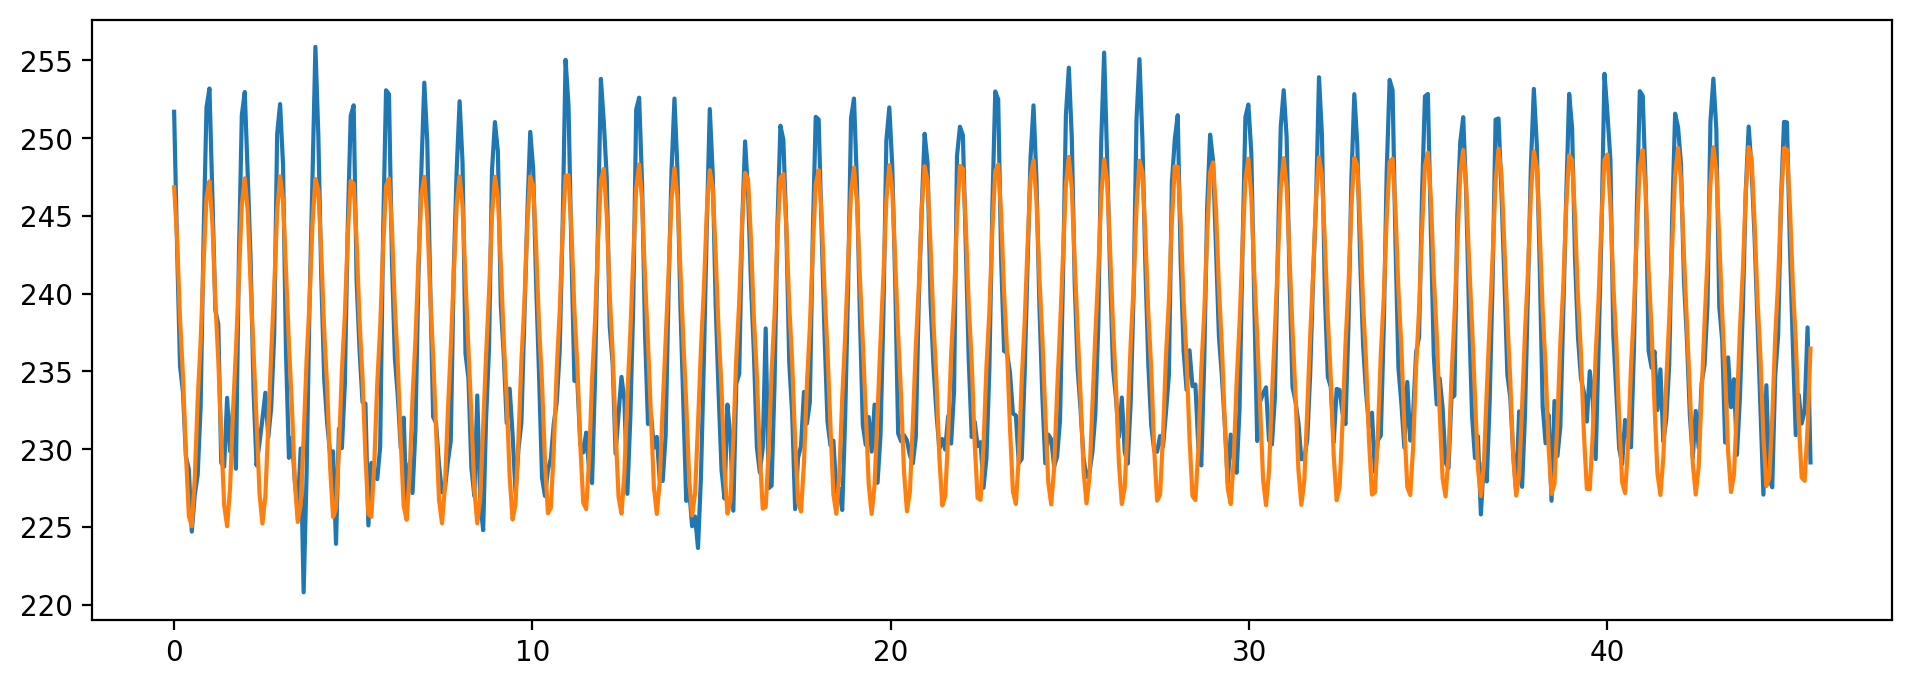

In [50]:
samples = ns_co2_seasonal_cr.get_samples(random.PRNGKey(3), num_samples=1000)
log_Z_mean = np.array(ns_co2_seasonal_cr._results.log_Z_mean).astype('float64')

sigma = np.array(jnp.median(samples['sigma'])).astype('float64')

# Offset
offset = np.array(jnp.median(samples['offset'])).astype('float64')

# Seasonal
seasonal_shift = np.array(jnp.median(samples['seasonal_shift'])).astype('float64')
seasonal_amplitude = np.array(jnp.median(samples['seasonal_amplitude'])).astype('float64')
seasonal_exponent = np.array(jnp.median(samples['seasonal_exponent'])).astype('float64')

# # ONI
# oni = oni_data
# orbits_oni = ((oni.time-np.min(geo_data_coarse30.time))/np.timedelta64(1, 'D')/365.256).values
# oni_gain = np.array(jnp.median(samples['oni_gain'])).astype('float64')
# oni_shift = np.array(jnp.median(samples['oni_shift'])).astype('float64')

# CR
orbits_cr = ((cr.time-np.min(geo_data_coarse30.time))/np.timedelta64(1, 'D')/365.256).values
cr_gain = np.array(jnp.median(samples['cr_gain'])).astype('float64')
cr_shift = np.array(jnp.median(samples['cr_shift'])).astype('float64')


# CO2
co2_gain = np.array(jnp.median(samples['co2_gain'])).astype('float64')

fig = plt.figure(figsize=np.array([9, 3]), dpi=200)
gs0 = fig.add_gridspec(1, 1, wspace=0.0, hspace=0, left=0, right=1, bottom=0, top=1)

ax = fig.add_subplot(gs0[0, 0])
ax.plot(orbits, target_variable)


sin_orbits = jnp.sin((orbits - seasonal_shift)*2*jnp.pi)
precipitation_estimate = (seasonal_amplitude*jnp.sign(sin_orbits)*jnp.pow(jnp.abs(sin_orbits), seasonal_exponent)
                            + orbits/jnp.max(orbits)*co2_gain  + offset
                            + cr_gain*jnp.interp(orbits-jnp.abs(cr_shift), orbits_cr, cr.normalized.values))
ax.plot(orbits, precipitation_estimate)


INFO:jaxns:Number of parallel Markov-chains set to: 13


--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 103139
samples: 4831
phantom samples: 4380
likelihood evals / sample: 21.3
phantom fraction (%): 90.7%
--------
logZ=-1548.6 +- 1.7
max(logL)=-1520.5
H=-24.73
ESS=23
--------
co2_gain: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
co2_gain: 2.66 +- 0.56 | 2.03 / 2.5 / 3.4 | 2.5 | 2.5
--------
cr_gain: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
cr_gain: -0.198 +- 0.091 | -0.312 / -0.19 / -0.082 | -0.11 | -0.11
--------
cr_shift: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
cr_shift: 0.572 +- 0.055 | 0.508 / 0.564 / 0.651 | 0.644 | 0.644
--------
offset: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
offset: 235.96 +- 0.31 | 235.52 / 236.01 / 236.31 | 236.07 | 236.07
--------
oni_gain: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
oni_gain: -0.11 +- 0.1 | -0.25 / -0.13 / 0.01 | -0.01 | -0

/d0/amunozj/.conda/envs/sun-climate-bayes/lib/python3.12/site-packages/jaxns/plotting.py:45: UserWarning: Found samples with zero likelihood evaluations.
  warnings.warn("Found samples with zero likelihood evaluations.")


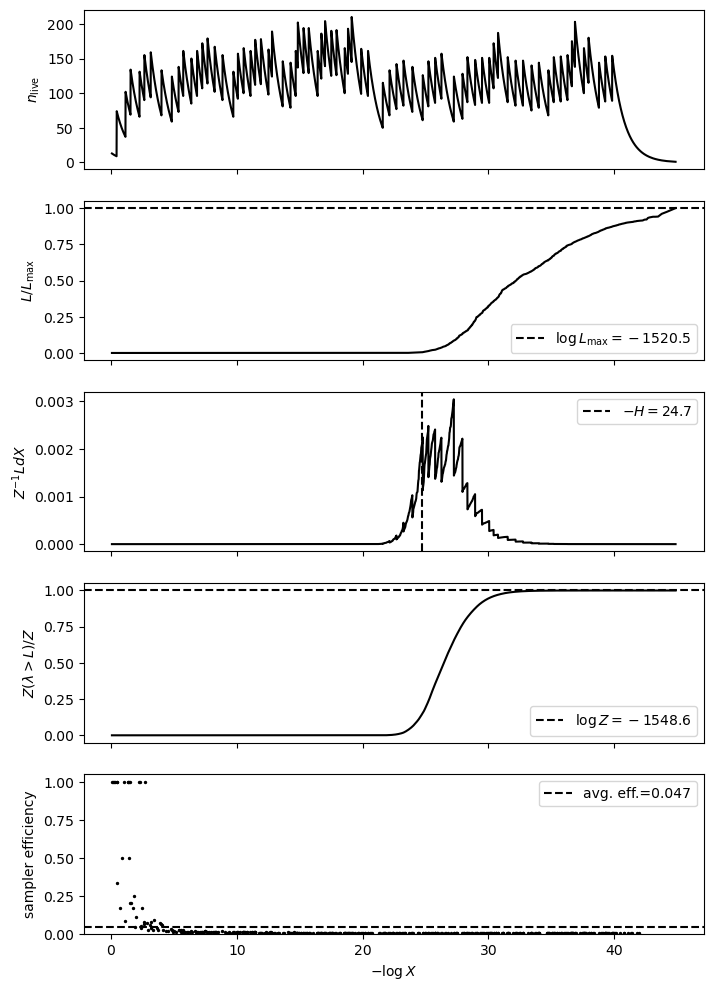

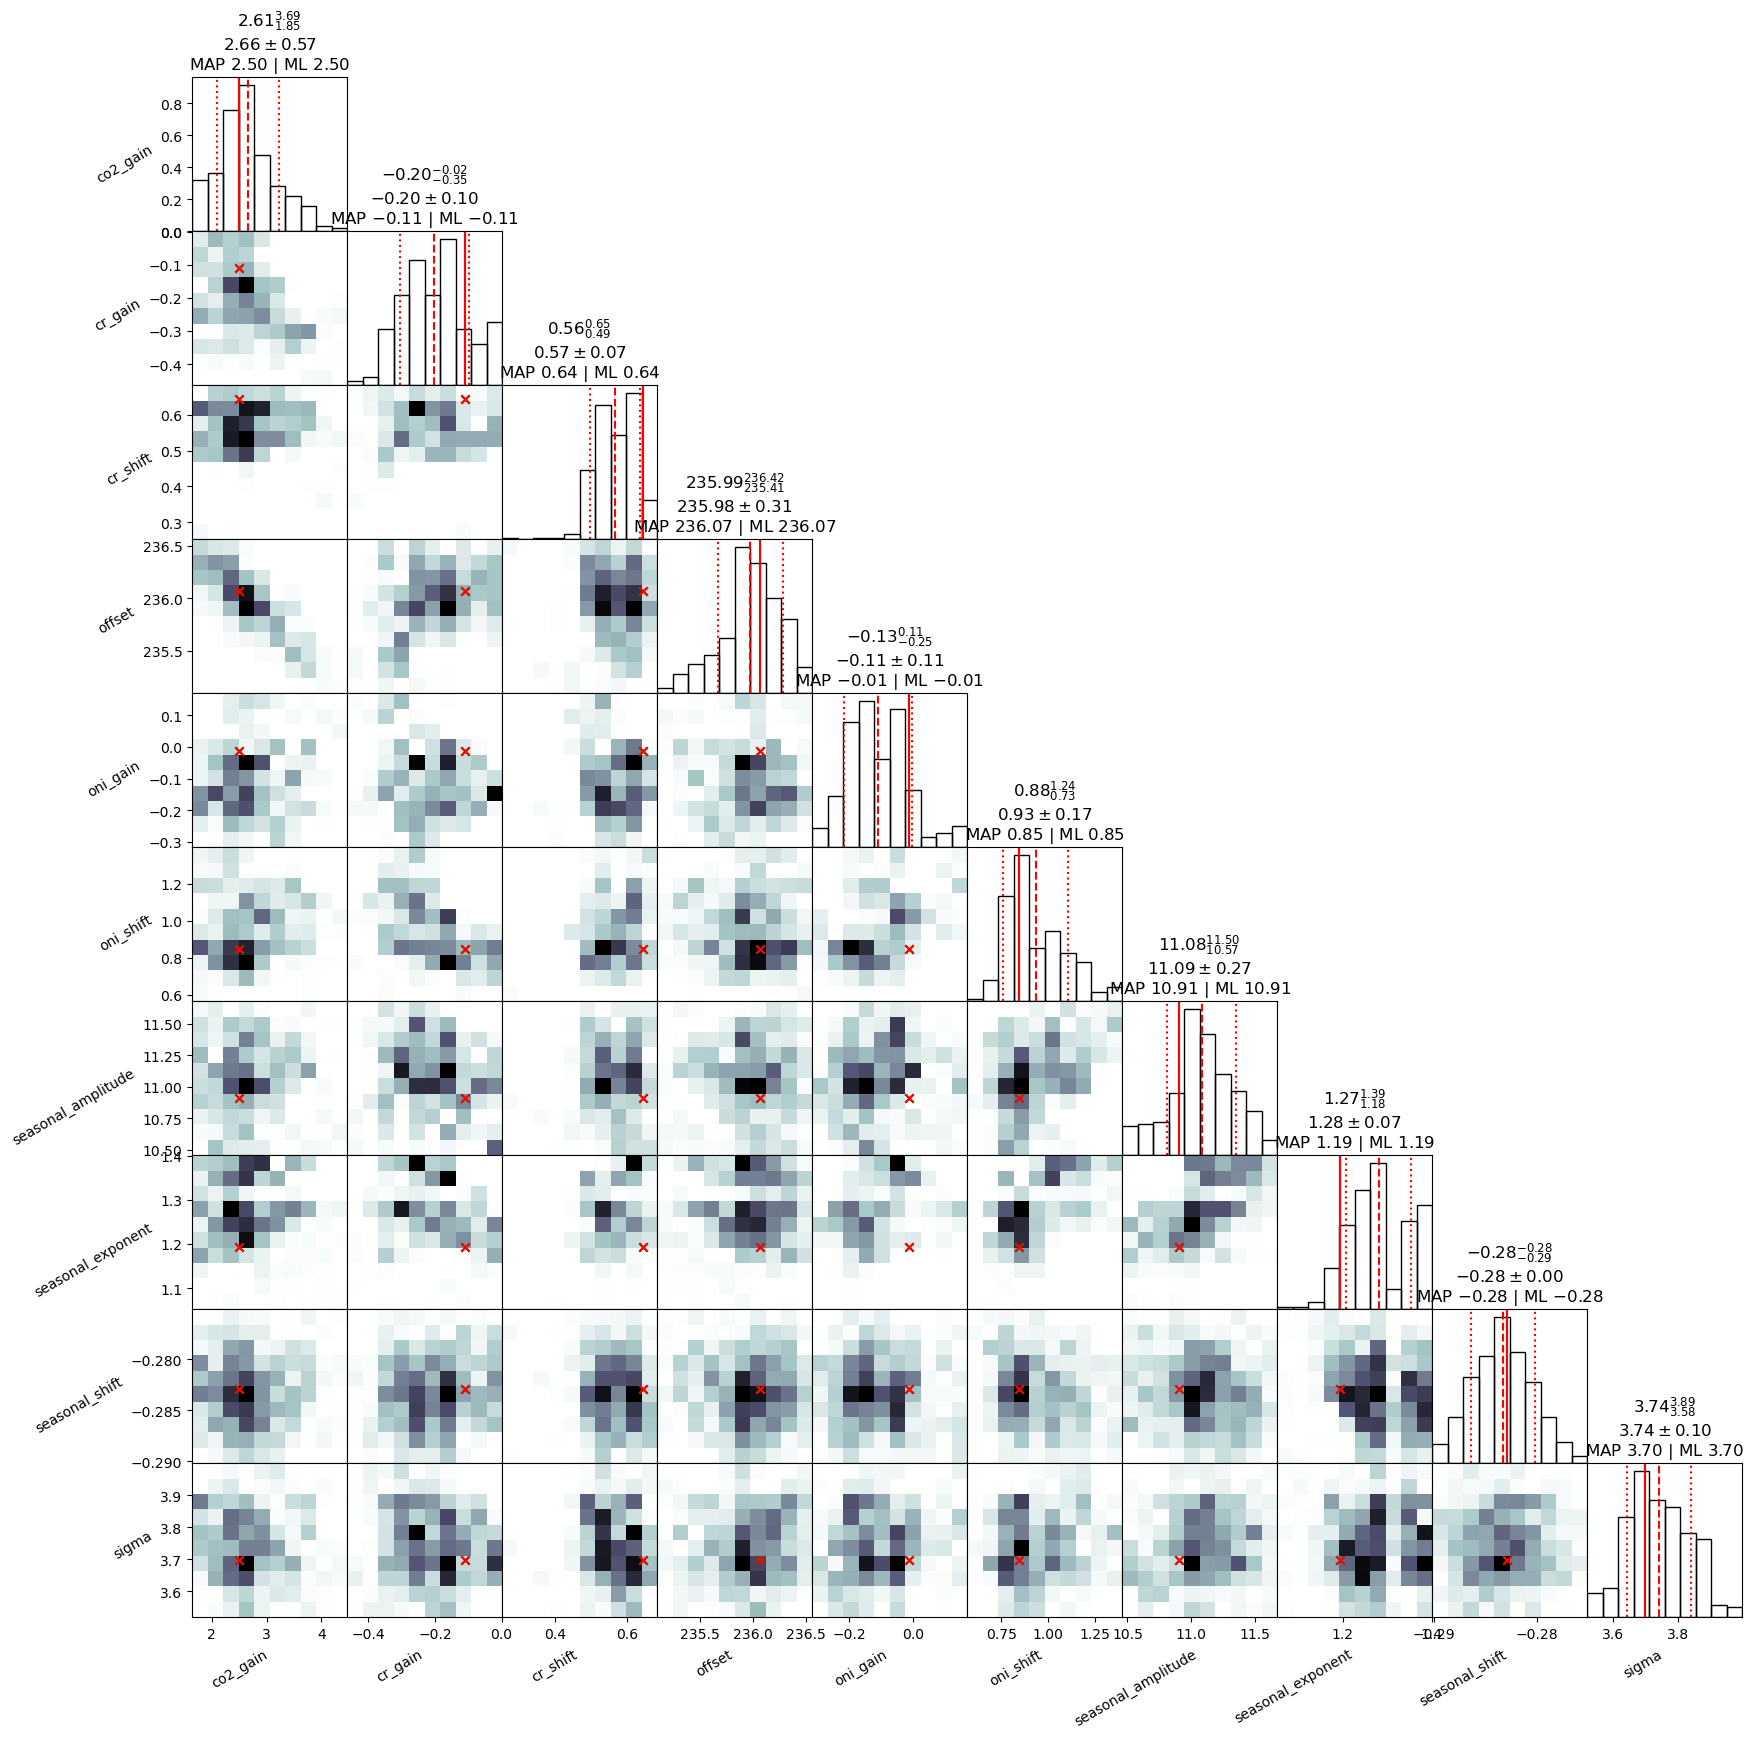

In [51]:
ns_co2_seasonal_oni_cr = NestedSampler(single_lat_lon_model, constructor_kwargs=constructor_kwargs)
ns_co2_seasonal_oni_cr.run(random.PRNGKey(2), geo_data_coarse30.time, target_variable,
                                                    True, True, oni_data, cr)
ns_co2_seasonal_oni_cr.print_summary()
ns_co2_seasonal_oni_cr.diagnostics()

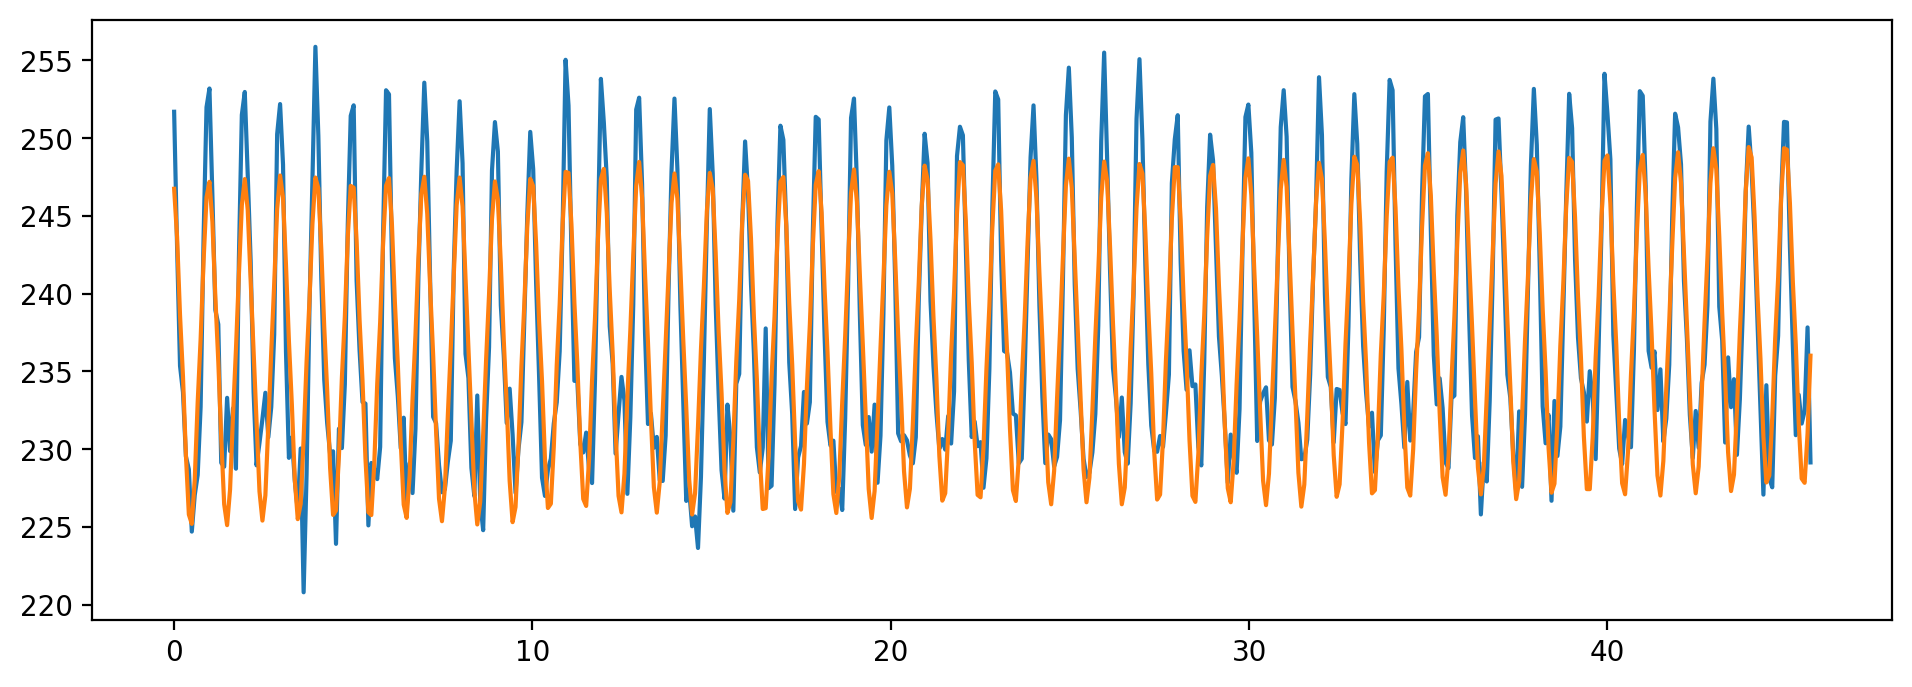

In [52]:
samples = ns_co2_seasonal_oni_cr.get_samples(random.PRNGKey(3), num_samples=1000)
log_Z_mean = np.array(ns_co2_seasonal_oni_cr._results.log_Z_mean).astype('float64')

sigma = np.array(jnp.median(samples['sigma'])).astype('float64')

# Offset
offset = np.array(jnp.median(samples['offset'])).astype('float64')

# Seasonal
seasonal_shift = np.array(jnp.median(samples['seasonal_shift'])).astype('float64')
seasonal_amplitude = np.array(jnp.median(samples['seasonal_amplitude'])).astype('float64')
seasonal_exponent = np.array(jnp.median(samples['seasonal_exponent'])).astype('float64')

# ONI
oni = oni_data
orbits_oni = ((oni.time-np.min(geo_data_coarse30.time))/np.timedelta64(1, 'D')/365.256).values
oni_gain = np.array(jnp.median(samples['oni_gain'])).astype('float64')
oni_shift = np.array(jnp.median(samples['oni_shift'])).astype('float64')

# CR
orbits_cr = ((cr.time-np.min(geo_data_coarse30.time))/np.timedelta64(1, 'D')/365.256).values
cr_gain = np.array(jnp.median(samples['cr_gain'])).astype('float64')
cr_shift = np.array(jnp.median(samples['cr_shift'])).astype('float64')


# CO2
co2_gain = np.array(jnp.median(samples['co2_gain'])).astype('float64')

fig = plt.figure(figsize=np.array([9, 3]), dpi=200)
gs0 = fig.add_gridspec(1, 1, wspace=0.0, hspace=0, left=0, right=1, bottom=0, top=1)

ax = fig.add_subplot(gs0[0, 0])
ax.plot(orbits, target_variable)


sin_orbits = jnp.sin((orbits - seasonal_shift)*2*jnp.pi)
precipitation_estimate = (seasonal_amplitude*jnp.sign(sin_orbits)*jnp.pow(jnp.abs(sin_orbits), seasonal_exponent)
                            + orbits/jnp.max(orbits)*co2_gain  + offset
                            + oni_gain*jnp.interp(orbits-jnp.abs(oni_shift), orbits_oni, oni.normalized.values)
                            + cr_gain*jnp.interp(orbits-jnp.abs(cr_shift), orbits_cr, cr.normalized.values))
ax.plot(orbits, precipitation_estimate)